In [2]:
import os
import sys

import numpy as np

import torch
import pytorch3d
from pytorch3d.io import load_obj, save_obj
from pytorch3d.structures import Meshes, Pointclouds
from pytorch3d.ops import sample_points_from_meshes #,knn_points, estimate_pointcloud_normals, knn_gather

import trimesh


from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [3]:
from ops.utils import *

from ops.mesh_curvature import Gaussian_curvature, Dual_area_for_vertices,Average_from_verts_to_face
from ops.pcl_curvature import Weingarten_maps, Curvature_pcl


In [4]:
# Set the device
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

For Mesh

In [ ]:
# Load the kitty mesh.
trg_obj = 'kitty.obj'

# We read the target 3D model using load_obj
verts, faces, aux = load_obj(trg_obj)

# verts is a FloatTensor of shape (V, 3) where V is the number of vertices in the mesh
# faces is an object which contains the following LongTensors: verts_idx, normals_idx and textures_idx
# For this tutorial, normals and textures are ignored.
faces_idx = faces.verts_idx.to(device)
verts = verts.to(device)

# We scale normalize and center the target mesh to fit in a sphere of radius 1 centered at (0,0,0). 
center = verts.mean(0)
verts = verts - center
scale = max(verts.abs().max(0)[0])
verts = verts / scale

# We construct a Meshes structure for the target mesh
trg_mesh = Meshes(verts=[verts], faces=[faces_idx])

In [6]:
points_np = trg_mesh.verts_packed().cpu().numpy()
faces_np = trg_mesh.faces_packed().cpu().numpy()
mesh_np = trimesh.Trimesh(vertices=points_np, faces=faces_np)

In [7]:
gaussian_curvature = Gaussian_curvature(trg_mesh)

In [8]:
# gaussian curvature of the faces
gaussian_curvature_faces = Average_from_verts_to_face(trg_mesh,gaussian_curvature.T).cpu().numpy()

In [9]:
# Histogram equalization of the gaussian curvature
gaussian_curvature_equalized = Histogram_equalization(gaussian_curvature_faces)

In [ ]:
# color the mesh by the gaussian curvature
mesh_np.visual.face_colors = trimesh.visual.interpolate(gaussian_curvature_equalized, color_map='jet')
mesh_np.show()

In [11]:
dual_area_vertex = Dual_area_for_vertices(trg_mesh)

In [12]:
# discrete Gauss-Bonnet theorem
print("Gauss-Bonnet theorem: integral of gaussian_curvature - 2*pi*X = ",(gaussian_curvature*dual_area_vertex).sum().cpu().numpy() - 2*np.pi*mesh_np.euler_number)

Gauss-Bonnet theorem: integral of gaussian_curvature - 2*pi*X =  0.0017461776733398438


For PCL

In [13]:
pointscloud = sample_points_from_meshes(trg_mesh, 100000)

pointscloud_np = pointscloud.cpu().numpy()[0]

In [14]:
k = 50 # number of nearest neighbors
Weingarten_fields, normals_field, tangent1_field, tangent2_field = Weingarten_maps(pointscloud,k)

In [15]:
# construct the principal frame by principal curved directions and normals
principal_curvatures, principal_direction, normals_field =  Curvature_pcl(pointscloud,k,return_princpals=True)
principal_frame = torch.cat([principal_direction,normals_field[:,:,None,:]],dim=-2)

In [16]:
# Gaussian curvature is the determinant of the Weingarten map
gaussian_curvature_pc = torch.det(Weingarten_fields)
gaussian_curvature_pc_np = gaussian_curvature_pc.cpu().numpy()[0]
# Mean curvature is the trace of the Weingarten map
mean_curvature_pc = Weingarten_fields.diagonal(offset=0, dim1=-1, dim2=-2).sum(-1)
mean_curvature_pc_np = mean_curvature_pc.cpu().numpy()[0]

In [17]:
# Remove the singularities
bound = 1e2

gaussian_curvature_pc_np[(gaussian_curvature_pc_np)>bound] = bound
gaussian_curvature_pc_np[(gaussian_curvature_pc_np)<-bound] = -bound

mean_curvature_pc_np[(gaussian_curvature_pc_np)>bound] = bound
mean_curvature_pc_np[(gaussian_curvature_pc_np)<-bound] = -bound

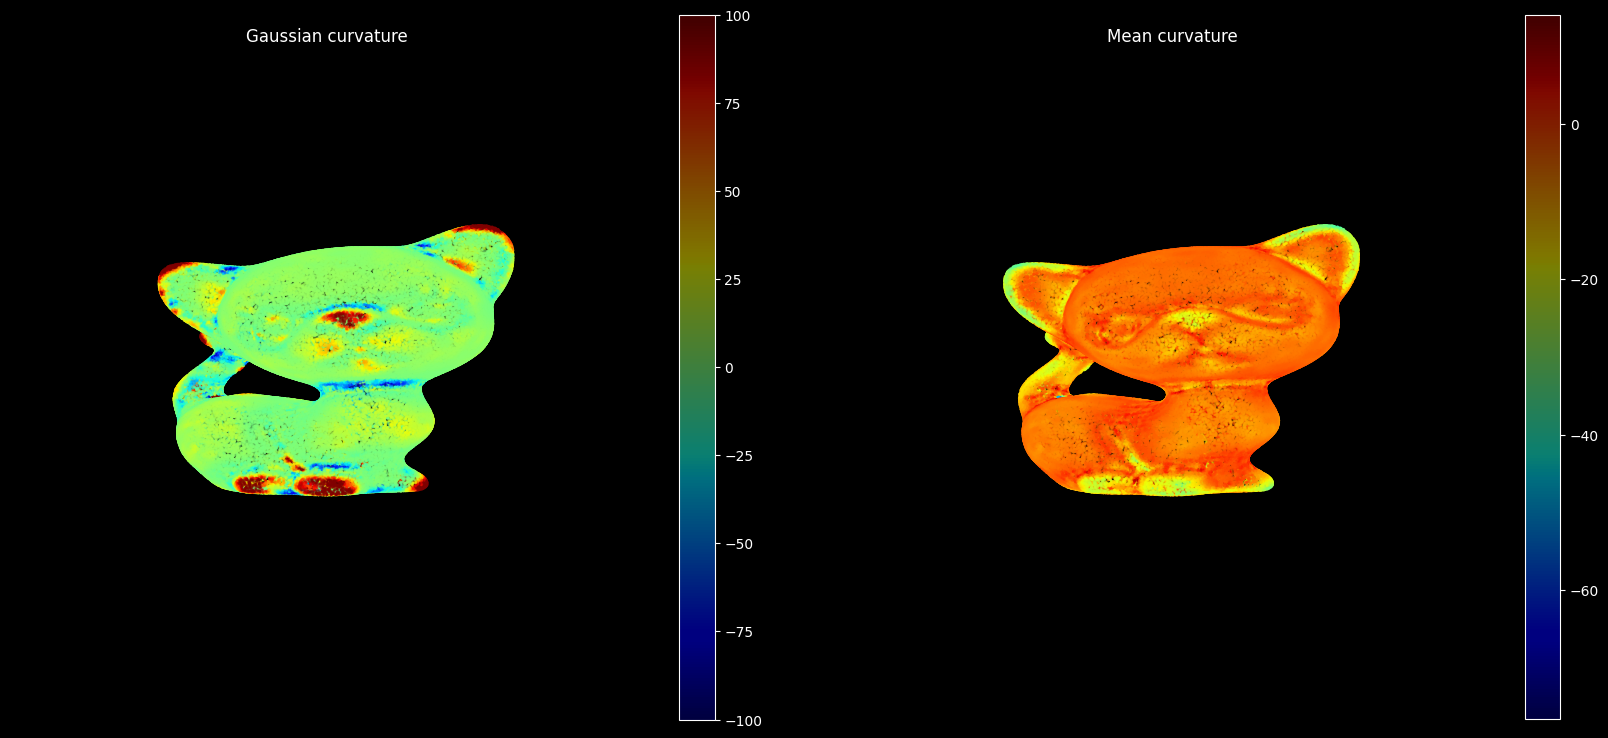

In [18]:
# show the 3D point cloud
fig = plt.figure(figsize=(20, 20))
ax1 = fig.add_subplot(121, projection='3d')
sc1 = ax1.scatter(pointscloud_np[:,0], pointscloud_np[:,1], pointscloud_np[:,2], c =gaussian_curvature_pc_np, s=5, cmap=plt.cm.jet, marker='.',alpha = 0.5)
# without grid and axis
ax1.grid(False)
ax1.axis('off')
ax1.set_title('Gaussian curvature')
plt.colorbar(sc1,fraction=0.05, pad=0.05)
# angle of view
ax1.view_init(azim=-90, elev=180)

ax2 = fig.add_subplot(122, projection='3d')
sc2 = ax2.scatter(pointscloud_np[:,0], pointscloud_np[:,1], pointscloud_np[:,2], c =mean_curvature_pc_np, s=5, cmap=plt.cm.jet, marker='.',alpha = 0.5)
# without grid and axis
ax2.grid(False)
ax2.axis('off')
ax2.set_title('Mean curvature')
plt.colorbar(sc2,fraction=0.05, pad=0.05)
# angle of view
ax2.view_init(azim=-90, elev=180)

plt.show()